# Introduction
Italian cuisine is one of the best in the world. The aim of this project is to find the most popular neighborhoods with italian restaurants in the Big Apple. This can be useful for suggesting where to open another restaurant that can be the bearer of our beautiful culture. As part of this project, we will list and visualize all major New York City's boroughs that have great Italian resturants based on ratings, tips and likes. We will then conclude by proposing the most suitable and competitive neighborhood for opening a new activity.

# Data For this project we need the following data :

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. Data source : https://cocl.us/new_york_dataset Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city. Italian resturants in each neighborhood of new york city. Data source : Fousquare API Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants. GeoSpace data Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

# Analysis

#### Required Libraries
pandas and numpy for handling data.
request module for using FourSquare API.
geopy to get co-ordinates of City of New York.
folium to visualize the results on a map

In [73]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [74]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to interact with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category

In [75]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'ELWK1J2QKRNRWKWHRS0E3QZSEAGL4TLJ5SJOG41SNKGZQPNJ' # your Foursquare ID
    CLIENT_SECRET = 'AE3G4B04OWYSSX4AKA1NEGRKKBZNTQCQUYQSK13RHXWMESB4' 
    VERSION = '20201111' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [76]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'ELWK1J2QKRNRWKWHRS0E3QZSEAGL4TLJ5SJOG41SNKGZQPNJ' # My Foursquare ID
    CLIENT_SECRET = 'AE3G4B04OWYSSX4AKA1NEGRKKBZNTQCQUYQSK13RHXWMESB4' 
    VERSION = '20201111' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [77]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [78]:
new_york_data=get_new_york_data()
new_york_data.head(15)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [79]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

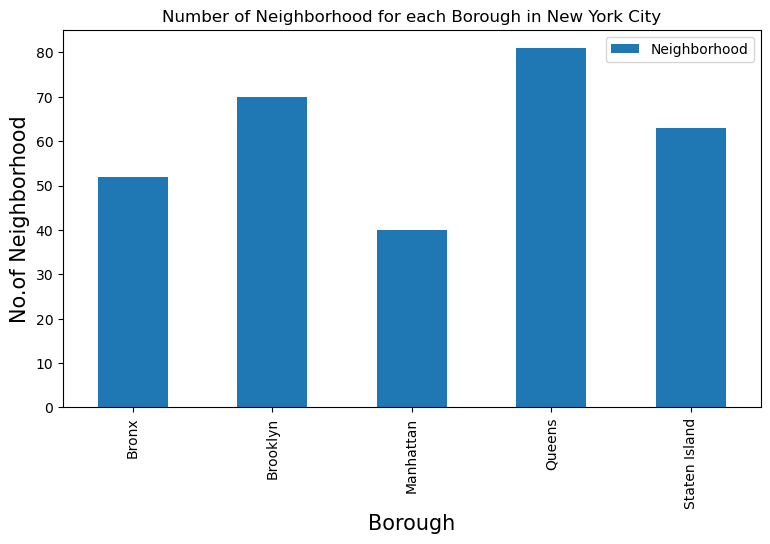

In [80]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods
Now we will collect Italian resturants for each Neighborhood

In [28]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:1
done
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:1
done
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:2
done
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Italian Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Italian Resturants in Baychester, Bronx:2
done
( 12 / 306 ) Italian Resturants in Pelham Parkway, Bronx:3
done
( 13 / 306 ) Italian Resturants in City Island, Bronx:3
done
( 14 / 306 ) Italian Resturants in Bedford Park, Bronx:1
done
( 15 / 306 ) Italian Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Italian Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Italian R

done
( 130 / 306 ) Italian Resturants in Astoria, Queens:1
done
( 131 / 306 ) Italian Resturants in Woodside, Queens:0
done
( 132 / 306 ) Italian Resturants in Jackson Heights, Queens:1
done
( 133 / 306 ) Italian Resturants in Elmhurst, Queens:0
done
( 134 / 306 ) Italian Resturants in Howard Beach, Queens:4
done
( 135 / 306 ) Italian Resturants in Corona, Queens:3
done
( 136 / 306 ) Italian Resturants in Forest Hills, Queens:2
done
( 137 / 306 ) Italian Resturants in Kew Gardens, Queens:0
done
( 138 / 306 ) Italian Resturants in Richmond Hill, Queens:1
done
( 139 / 306 ) Italian Resturants in Flushing, Queens:0
done
( 140 / 306 ) Italian Resturants in Long Island City, Queens:3
done
( 141 / 306 ) Italian Resturants in Sunnyside, Queens:1
done
( 142 / 306 ) Italian Resturants in East Elmhurst, Queens:1
done
( 143 / 306 ) Italian Resturants in Maspeth, Queens:2
done
( 144 / 306 ) Italian Resturants in Ridgewood, Queens:3
done
( 145 / 306 ) Italian Resturants in Glendale, Queens:1
done
(

done
( 255 / 306 ) Italian Resturants in Concord, Staten Island:5
done
( 256 / 306 ) Italian Resturants in Emerson Hill, Staten Island:1
done
( 257 / 306 ) Italian Resturants in Randall Manor, Staten Island:1
done
( 258 / 306 ) Italian Resturants in Howland Hook, Staten Island:0
done
( 259 / 306 ) Italian Resturants in Elm Park, Staten Island:2
done
( 260 / 306 ) Italian Resturants in Remsen Village, Brooklyn:1
done
( 261 / 306 ) Italian Resturants in New Lots, Brooklyn:0
done
( 262 / 306 ) Italian Resturants in Paerdegat Basin, Brooklyn:0
done
( 263 / 306 ) Italian Resturants in Mill Basin, Brooklyn:3
done
( 264 / 306 ) Italian Resturants in Jamaica Hills, Queens:0
done
( 265 / 306 ) Italian Resturants in Utopia, Queens:1
done
( 266 / 306 ) Italian Resturants in Pomonok, Queens:1
done
( 267 / 306 ) Italian Resturants in Astoria Heights, Queens:3
done
( 268 / 306 ) Italian Resturants in Claremont Village, Bronx:0
done
( 269 / 306 ) Italian Resturants in Concourse Village, Bronx:2
done


Now that we have got all the italian resturants in new york city , we will analyze it

In [81]:
italian_rest_ny.head(15)

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's
5,Bronx,Baychester,5411894d498e4a254a11a46c,Olive Garden
6,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's
7,Bronx,Pelham Parkway,4b10591af964a5205f6e23e3,Patricia's
8,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta
9,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood


In [82]:
italian_rest_ny.shape

(536, 4)

We got 536 Indian Resturants across New York City

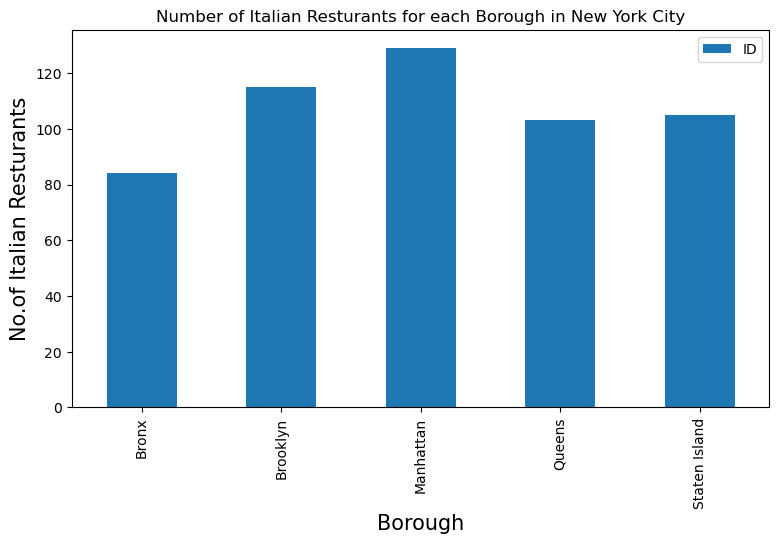

In [83]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Manhattam has the largest number of italian resturants

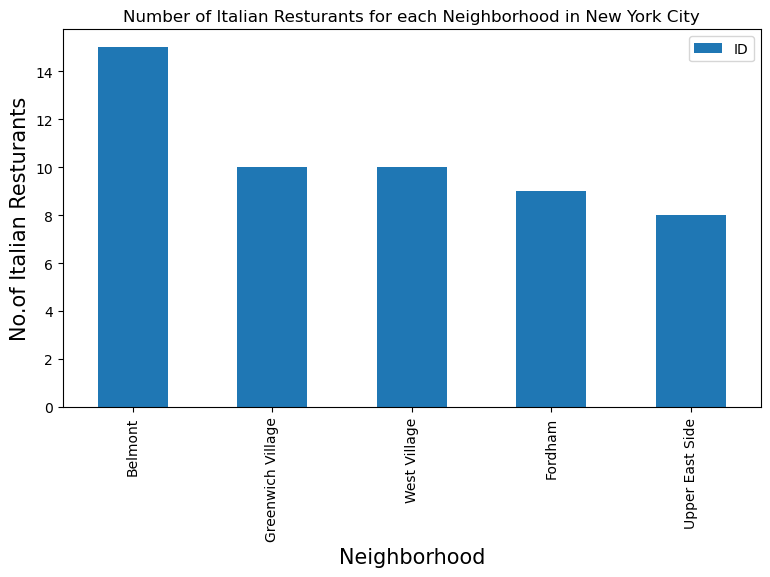

In [84]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [85]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
44,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
45,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
46,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
47,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
48,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant
49,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
50,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
51,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
52,Bronx,Belmont,4aa193d5f964a520124120e3,Mario's Restaurant & Catering
53,Bronx,Belmont,4a8e261cf964a5201c1220e3,Roberto's


So Belmont in Manhattam has the highest number of Italian Resturants with a total count of 9. Now we will get the ranking of each resturant for further analysis.

In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_ny_rating=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_ny_rating = italian_rest_ny_rating.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [36]:
italian_rest_ny_rating.to_csv('italian_rest_rating_ny.csv', index=False)

Lets verify the data from saved csv file

In [87]:
italian_rest_ny_rating_csv=pd.read_csv('italian_rest_rating_ny.csv')

In [88]:
italian_rest_ny_rating_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,7.0,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,7.0,4
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.4,14
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.5,8
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's,22,8.6,6


In [89]:
italian_rest_ny_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       0 non-null      object
 1   Neighborhood  0 non-null      object
 2   ID            0 non-null      object
 3   Name          0 non-null      object
 4   Likes         0 non-null      object
 5   Rating        0 non-null      object
 6   Tips          0 non-null      object
dtypes: object(7)
memory usage: 0.0+ bytes


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [42]:
italian_rest_ny_rating['Likes']=italian_rest_ny_rating['Likes'].astype('float64')

In [43]:
italian_rest_ny_rating['Tips']=italian_rest_ny_rating['Tips'].astype('float64')

In [44]:
italian_rest_ny_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       0 non-null      object 
 1   Neighborhood  0 non-null      object 
 2   ID            0 non-null      object 
 3   Name          0 non-null      object 
 4   Likes         0 non-null      float64
 5   Rating        0 non-null      object 
 6   Tips          0 non-null      float64
dtypes: float64(2), object(5)
memory usage: 0.0+ bytes


In [90]:
ny_neighborhood_stats=italian_rest_ny_rating_csv.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [91]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
2,Belmont,8.716667
9,Morrisania,8.400000
5,Fordham,8.344444
0,Baychester,8.050000
14,Van Nest,8.000000
7,Melrose,7.750000
11,Pelham Parkway,7.733333
3,City Island,7.500000
1,Bedford Park,7.500000
8,Morris Park,7.460000


Above are the top neighborhoods with top average rating of Italian resturant

In [92]:
ny_borough_stats=italian_rest_ny_rating_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [93]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,7.594


Similarly these are the average rating of Italian Resturants 

Now We will join this dataset to original new york data to get lonitude and latitude

In [94]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [95]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [96]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Baychester,40.866858,-73.835798,8.050000
1,Bronx,Bedford Park,40.870185,-73.885512,7.500000
2,Bronx,Belmont,40.857277,-73.888452,8.716667
3,Bronx,City Island,40.847247,-73.786488,7.500000
4,Bronx,Country Club,40.844246,-73.824099,5.375000
5,Bronx,Fordham,40.860997,-73.896427,8.344444
6,Bronx,Kingsbridge,40.881687,-73.902818,7.000000
7,Bronx,Melrose,40.819754,-73.909422,7.750000
8,Bronx,Morris Park,40.847549,-73.850402,7.460000
9,Bronx,Morrisania,40.823592,-73.901506,8.400000


The last thing to do, is showing this data on a map

In [97]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [98]:

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [99]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [100]:

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)